In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
path = 'data'
train_data = datasets.MNIST(root=path, train=True, transform=transforms.Compose([
    transforms.ToTensor()
]), download=False)
train_data = DataLoader(dataset=train_data, batch_size=128, shuffle=True)

test_data = datasets.MNIST(root=path, train=False, transform=transforms.Compose([
    transforms.ToTensor()
]), download=False)
test_data = DataLoader(dataset=test_data, batch_size=128, shuffle=True)

x, _ = iter(train_data).next()

In [3]:
x.shape

torch.Size([128, 1, 28, 28])

In [4]:
from torch import nn
import numpy as np

In [5]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        :param x: 输入
        :return: x_hat和kl散度
        """
        batch_size = x.size(0)
        x = x.view(batch_size, 28*28)
        h_ = self.encoder(x)
        mu, sigma = h_.chunk(2, dim=1)
        h = mu + sigma * torch.randn_like(sigma)
        x = self.decoder(h)
        x = x.view(batch_size, 1, 28, 28)

        kld = 0.5 * torch.sum(
            torch.pow(mu, 2) +
            torch.pow(sigma, 2) -
            torch.log(1e-8 + torch.pow(sigma, 2)) - 1
        ) / (batch_size * 28 * 28)  # np.prod(x.shape) = batch_size * channel * h * w

        return x, kld


In [6]:
device = torch.device('cuda')

In [7]:
model = AE().to(device)
loss_function = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
import tqdm

In [9]:
for epoch in range(1):
    for train_x, _ in tqdm.tqdm(train_data):
        train_x = train_x.to(device)

        x_hat, kld = model(train_x)

        loss = loss_function(x_hat, train_x)

        if kld is not None:
            e = - loss - kld
            loss = - e

        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f'epoch: {epoch + 1}, loss: {loss.item()}, kld: {kld.item()}')


100%|██████████| 469/469 [00:11<00:00, 39.65it/s]


epoch: 1, loss: 0.061559949070215225, kld: 0.0034757652319967747


100%|██████████| 469/469 [00:11<00:00, 39.60it/s]


epoch: 2, loss: 0.05652080103754997, kld: 0.004484245087951422


100%|██████████| 469/469 [00:11<00:00, 41.44it/s]


epoch: 3, loss: 0.05860079452395439, kld: 0.0054840222001075745


100%|██████████| 469/469 [00:11<00:00, 41.39it/s]


epoch: 4, loss: 0.05375172197818756, kld: 0.005136073566973209


100%|██████████| 469/469 [00:11<00:00, 40.27it/s]

epoch: 5, loss: 0.05786272883415222, kld: 0.005433603655546904


In [10]:
import matplotlib.pyplot as plt

In [11]:
device_cpu = torch.device('cpu')
model = model.to(device_cpu)

(-0.5, 27.5, 27.5, -0.5)

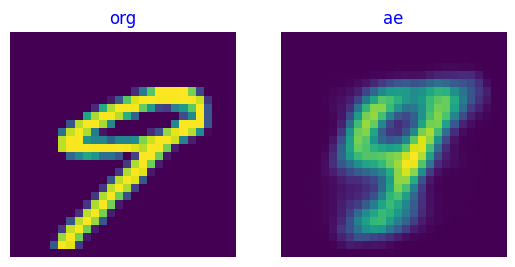

In [15]:
x_eval, _ = iter(test_data).__next__()
x_hat, kld_ = model(x_eval)
x_eval1 = x_eval[0].detach().numpy()
x_hat1 = x_hat[0].detach().numpy()

plt.subplot(1, 2, 1)
plt.title("org", color='blue')
plt.imshow(np.squeeze(x_eval1))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("ae", color='blue')
plt.imshow(np.squeeze(x_hat1))
plt.axis("off")